<a href="https://colab.research.google.com/github/abbassix/generalizing-RegEx-with-LSTM/blob/main/regex_bidirectional_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# generate simple regexes like ab[ca]db
def regex_generator(length=4.79, n_det=0, n_undet=0, letters='abcdefghijklmnopqrstuvwxyz', nails_length=4):
  import random
  def inject(string, positions, nails):
    positions = [0] + sorted(positions * 2) + [len(string)]
    positions = [(positions[i], positions[i+1]) for i in range(0, len(positions), 2)]
    partitions = [string[i:j] for (i, j) in positions]
    return(''.join([p_+n_ for p_, n_ in zip(partitions, nails)])+partitions[-1])

  if n_det == 0:
    n_det = max(round(random.gauss(length, 1)), 3)
  if n_undet == 0:
    n_undet = random.randint(1, round((n_det-1)/2))
    
  positions = sorted([random.randint(1, int(length) - 1) for _ in range(n_undet)])
    
  regex_det = ''.join([random.choice(letters) for i in range(n_det)])
    
  nails = ['[' + ''.join([random.choice(letters) for _ in range(random.randint(2, nails_length))]) + ']' for _ in range(n_undet)]

  regex_sample = inject(regex_det, positions, nails)

  return(regex_sample)

# TO DO: more complex structures

In [2]:
# install rstr to make samples from regexes as training data
!pip install rstr

In [3]:
# decode regexes into samples
def regex_decoder(regex):
  import rstr
  return(rstr.xeger(regex))

In [4]:
# generate 5000 regexes
y = [regex_generator(length=5, nails_length=2) for _ in range(5000)]

In [5]:
# generate samples from regexes and remove the repetitions
X = [list(set([regex_decoder(regex) for _ in range(100)])) for regex in y]

In [6]:
# make the dataset as a Pandas Data Frame
import pandas as pd
trainset = pd.DataFrame({'X': X, 'y': y})

In [7]:
# remove those who have only one sample as training and so there could be no generalization at all
trainset = trainset[trainset.X.apply(lambda x: len(x) >= 2)]

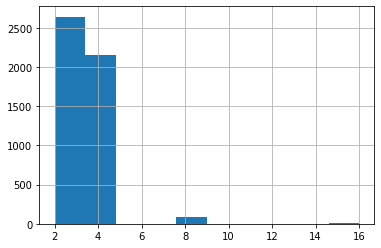

In [8]:
# show histogram of number of samples
trainset.X.apply(lambda x: len(x)).hist()

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [10]:
trainset.describe()

,X,y
count,4883,4883
unique,4883,4883
top,"[hwyumb, hyyuhb, hyyumb, hwyuhb]",pvg[wt][op]lm
freq,1,1


In [11]:
batch_size = 64  # Batch size for training.
epochs = 6  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 4800  # Number of samples to train on.

In [12]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set(' ')
target_characters = set(' ')

for index, row in trainset.iterrows():
    input_text, target_text = row[0], row[1]
    # convert the input from list to string
    input_text = '•'.join(input_text)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0  # one-hot encoding
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0  # padding the rest with space
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 4883
Number of unique input tokens: 28
Number of unique output tokens: 31
Max sequence length for inputs: 223
Max sequence length for outputs: 27


In [13]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.Bidirectional(keras.layers.LSTM(latent_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [forward_h, forward_c, backward_h, backward_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.Bidirectional(keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True))
decoder_outputs, _, _, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [14]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)
# Save model
model.save("lstm_regex")


Epoch 1/6
69/69 [==============================] - 158s 2s/step - loss: 1.8906 - accuracy: 0.5657 - val_loss: 1.2732 - val_accuracy: 0.6567
Epoch 2/6
69/69 [==============================] - 148s 2s/step - loss: 1.1406 - accuracy: 0.6885 - val_loss: 0.7641 - val_accuracy: 0.7628
Epoch 3/6
69/69 [==============================] - 149s 2s/step - loss: 0.6272 - accuracy: 0.8232 - val_loss: 0.2678 - val_accuracy: 0.9470
Epoch 4/6
69/69 [==============================] - 150s 2s/step - loss: 0.1790 - accuracy: 0.9736 - val_loss: 0.0306 - val_accuracy: 0.9988
Epoch 5/6
69/69 [==============================] - 152s 2s/step - loss: 0.0228 - accuracy: 0.9985 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 6/6
69/69 [==============================] - 152s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.9949e-04 - val_accuracy: 1.0000


INFO:tensorflow:Assets written to: lstm_regex/assets


INFO:tensorflow:Assets written to: lstm_regex/assets


In [15]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("lstm_regex")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, forward_h_enc, forward_c_enc, backward_h_enc, backward_c_enc = model.layers[2].output  # lstm_1
encoder_states = [forward_h_enc, forward_c_enc, backward_h_enc, backward_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_forward_h = keras.Input(shape=(latent_dim,), name="input_3")  #
decoder_state_input_forward_c = keras.Input(shape=(latent_dim,), name="input_4")  #
decoder_state_input_backward_h = keras.Input(shape=(latent_dim,), name="input_5")  #
decoder_state_input_backward_c = keras.Input(shape=(latent_dim,), name="input_6")  #
decoder_states_inputs = [decoder_state_input_forward_h, decoder_state_input_forward_c, decoder_state_input_backward_h, decoder_state_input_backward_c]
decoder_lstm = model.layers[3]
decoder_outputs, forward_h_dec, forward_c_dec, backward_h_dec, backward_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [forward_h_dec, forward_c_dec, backward_h_dec, backward_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, forward_h, forward_c, backward_h, backward_c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [forward_h, forward_c, backward_h, backward_c]
    return decoded_sentence


In [16]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: qumpoej•quzpohj•qumpohj•quzpoej
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: lmhvew•lmfvem•lmhvem•lmfvew
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: zkqiq•zkqyq
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: druormds•drucrmds
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: smlayg•smlayy•sklayy•sklayg
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: vbgvhsat•vwgvpsat•vbgvpsat•vwgvhsat
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: xnseuc•xnseac
Decoded sentence:                             
-
Input sentence: jjcwazj•jccwazj
Decoded sentence:                             
-
Input sentence: iudsmd•iudmmd•iudmmb•iudsmb
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: xpngaxo•xgngaxo•xpngmxo•xgngmxo
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: evcfb•evcfe
Decoded sentence: uuuuuuuuuuuuuuuuuuuuuuuuuuuu
-
Input sentence: qpgacb•qpgk